

# **Imports**


In [1]:
#! pip install statsmodels

In [2]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tensorflow.keras.layers import Dense, Dropout, LSTM
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Data import and analysis**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/dataset/stock_prices.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2138 non-null   object 
 1   Open    2138 non-null   float64
 2   High    2138 non-null   float64
 3   Low     2138 non-null   float64
 4   Close   2138 non-null   float64
 5   Volume  2138 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 100.3+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,2138.000000,2138.000000,2138.000000,2138.000000,2.138000e+03
mean,113.996712,116.478217,111.301449,114.050873,3.923548e+07
std,176.545649,180.531286,171.977626,176.596962,2.850304e+07
min,6.616000,6.676000,6.422000,6.582000,2.201000e+06
25%,41.934000,42.692499,41.259999,41.793500,2.134800e+07
50%,50.847001,51.661999,50.041000,50.832000,3.107200e+07
75%,68.631502,69.704500,67.359999,68.663000,4.659350e+07
max,891.380005,900.400024,871.599976,883.090027,3.046940e+08


In [6]:
df = df.drop(df.loc[:, ~df.columns.isin(['Date','Close'])].columns, axis = 1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

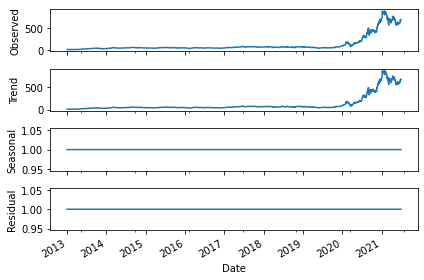

In [7]:
decompose = seasonal_decompose(df['Close'], model='multiplicative', freq=1)
decompose.plot();

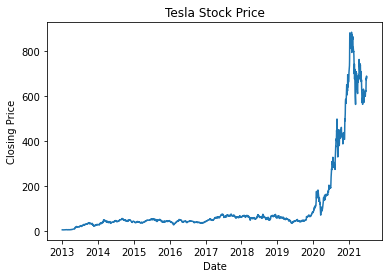

In [8]:
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Tesla Stock Price')
plt.plot(df['Close'])

Feature scaling

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

joblib.dump(scaler, "scaler_model.save") 

['scaler_model.save']

Data Split

In [10]:
sample, test = train_test_split(scaled_data, test_size=0.005, shuffle = False)
train, valid = train_test_split(sample, train_size = 0.85, shuffle = False)

Actual stock closing price from 15.06.2021 to 29.06.2021

In [11]:
test

array([[0.67629499],
       [0.68258131],
       [0.69596394],
       [0.70361934],
       [0.70078995],
       [0.70407572],
       [0.74156538],
       [0.76809109],
       [0.759021  ],
       [0.77824498],
       [0.76916353]])

# **Model1: ARIMA**

Check Stationarity using Dickey Fuller Test

In [12]:
df_arima = pd.DataFrame(df)

In [13]:
results = adfuller(df_arima['Close'])
if not results[1]<=0.05:
  print("Data is not Stationary")

Data is not Stationary


Making Data stationary using Differencing method

Data is Stationary


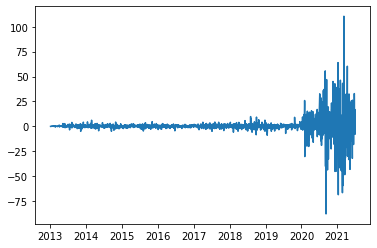

In [14]:
df_arima['Stationary_Close'] = df_arima['Close'] - df_arima['Close'].shift(1)
res = adfuller(df_arima['Stationary_Close'].dropna())
if res[1]<=0.05:
  print("Data is Stationary")
plt.plot(df_arima['Stationary_Close'])

Check Autocorelation and partial auto corelation

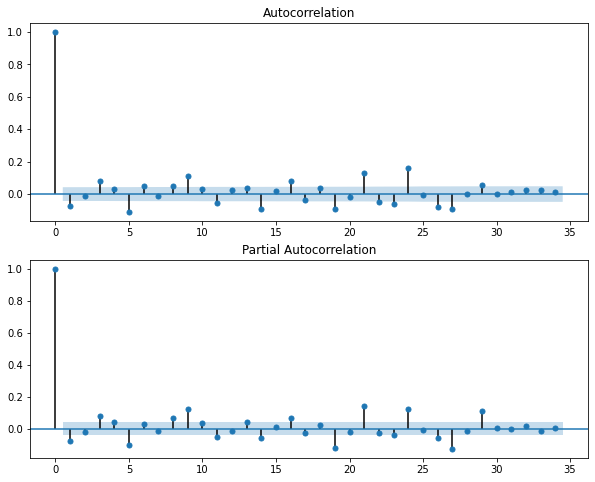

In [495]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(df_arima['Stationary_Close'].dropna(), ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_arima['Stationary_Close'].dropna(), ax = ax2)

ARIMA model

In [16]:
validation_Predict = []
train = train.ravel()
for i in range(0, len(valid)):
    model = ARIMA(train, order=(2,2,0))
    model_fit = model.fit(method_kwargs={"warn_convergence": False})
    forecast = model_fit.forecast()
    validation_Predict.append(forecast[0])
    train = np.concatenate((train, valid[i]), axis=0)

In [17]:
predictedData = pd.DataFrame(scaler.inverse_transform(train.reshape(-1, 1)))

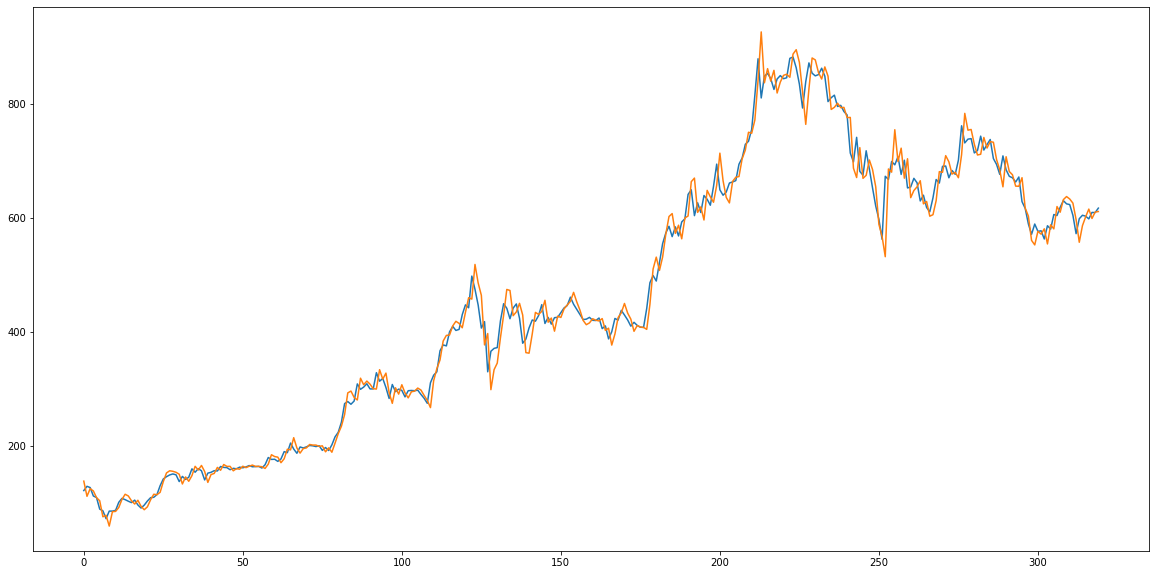

In [18]:
plt.figure(figsize=[20,10])
plt.plot(scaler.inverse_transform(valid))
plt.plot(scaler.inverse_transform(validation_Predict))

In [19]:
predicted_Test = []
for j in range(0, len(test)):
   model = ARIMA(train, order=(2, 2, 0))
   model_fit = model.fit(disp=0)
   fore_Test = model_fit.forecast()
   predicted_Test.append(fore_Test[0])
   train = np.concatenate((train, fore_Test[0]), axis=0)

In [20]:
#rmse value on the test data
result = mean_squared_error(scaler.inverse_transform(test), scaler.inverse_transform(predicted_Test), squared=False)
print(result)

18.384709675071065


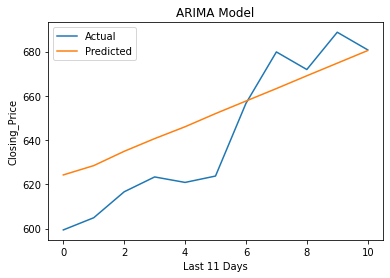

In [21]:
plt.xlabel('Last 11 Days')
plt.ylabel('Closing_Price')
plt.title('ARIMA Model')
plt.plot(scaler.inverse_transform(test), label = "Actual")
plt.plot(scaler.inverse_transform(predicted_Test), label = "Predicted")
plt.legend()

# **Model2: Support Vector Regression**

In [22]:
df_svr = pd.DataFrame(df)

In [23]:
df_svr = df_svr.drop(df_svr.loc[:, ~df_svr.columns.isin(['Close'])].columns, axis = 1)

Split Dataset


In [24]:
sample, test = train_test_split(df_svr, test_size=0.005, shuffle = False)
train, val = train_test_split(sample, train_size = 0.8, shuffle = False)

In [25]:
scaler_1 = MinMaxScaler(feature_range=(0,1))
scaled_data_train = scaler_1.fit_transform(train)
scaled_data_validate = scaler_1.fit_transform(val)

Create X, Y data 

In [26]:
timeStep = 16
train_X, train_Y = [], []
val_X, val_Y = [], []

for i in range(timeStep, len(scaled_data_train)):
  temp1 = scaled_data_train[i-timeStep:i, 0]   
  train_X.append(temp1)
  train_Y.append(scaled_data_train[i, 0])

for i in range(timeStep, len(scaled_data_validate)):
   temp2 = scaled_data_validate[i-timeStep:i, 0]  
   val_X.append(temp2)
   val_Y.append(scaled_data_validate[i, 0])


train_X, train_Y = np.array(train_X), np.array(train_Y)
val_X, val_Y = np.array(val_X), np.array(val_Y)

Model Creation

In [27]:
model_rbf = SVR(kernel='rbf', C=1000.0, gamma= 0.1)
model_rbf.fit(train_X, train_Y)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [28]:
prediction = model_rbf.predict(val_X)
prediction_Val = scaler_1.inverse_transform(prediction.reshape(-1,1))

In [29]:
val_Y_reshaped = scaler_1.inverse_transform(val_Y.reshape(1,-1))

Plot Validation data original vs predicted

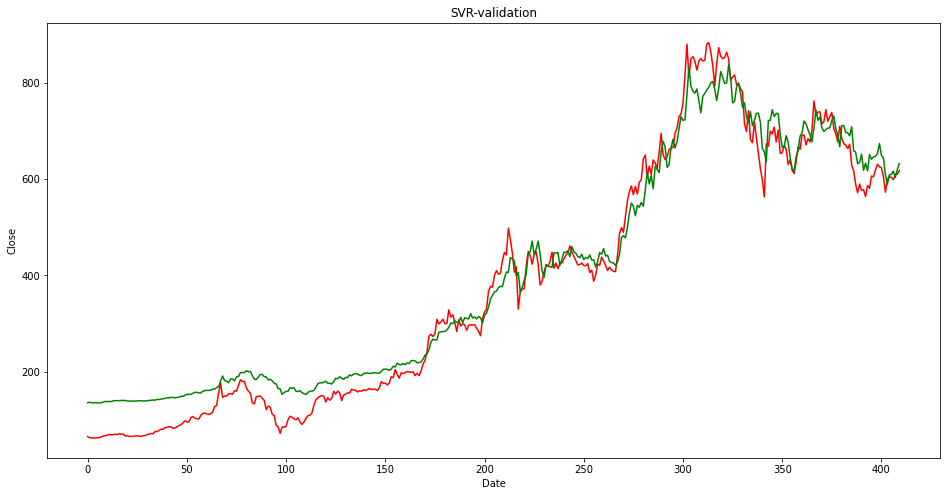

In [30]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('SVR-validation')
plt.plot(val_Y_reshaped[0], color = 'red', linewidth =1.5)
plt.plot(prediction_Val, color = 'green', linewidth = 1.5)

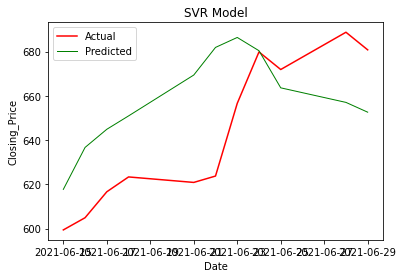

In [31]:
values = scaled_data_validate[len(scaled_data_validate)-timeStep:,]
a  = []
for i in range(0, len(sample)-timeStep+1):
   a.append(np.nan)
#plt.figure(figsize=(16, 10))
plt.xlabel("Date")
plt.ylabel("Closing_Price")
plt.title("SVR Model")
plot_df = df_svr.drop(['Close'], axis=1)
plt.plot(df_svr['Close'][2127:], color='red', label='Actual')
for i in range(0, len(test)-1):
   temp = values[len(values)-(timeStep):timeStep+i,0]
   input = temp.reshape((1, timeStep))
   prediction = model_rbf.predict(input)
   values = np.concatenate((values, prediction.reshape(1,-1)), axis=0)
values = scaler_1.inverse_transform(values)
c = []
for i in range(0, len(values)):
  c.append(values[i][0]) 
b = np.concatenate((a, c), axis=0)
plot_df.insert(0, "prediction", b, True)
plt.plot(plot_df[2127:], color='green', linewidth = 1, label='Predicted')
plt.legend()

In [32]:
#rmse value on the test data
result = mean_squared_error(df_svr['Close'][2127:], plot_df[2127:], squared=False)
print(result)

32.191370085395306


# **Model3- LSTM**

In [476]:
df_lstm = pd.DataFrame(df)

In [477]:
df_lstm= df_lstm.drop(df_lstm.loc[:, ~df_lstm.columns.isin(['Close'])].columns, axis = 1)

Split Dataset

In [478]:
sample, test = train_test_split(df_lstm, test_size=0.005, shuffle = False)
train, val = train_test_split(sample, train_size = 0.80, shuffle = False)

In [479]:
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaled_data_train = scaler_2.fit_transform(train)
scaled_data_validate = scaler_2.fit_transform(val)

In [480]:
timeStep = 50
train_X, train_Y = [], []
val_X, val_Y = [], []
for i in range(timeStep, len(scaled_data_train)):
  train_X.append(scaled_data_train[i-timeStep:i, 0])
  train_Y.append(scaled_data_train[i, 0])

for i in range(timeStep, len(scaled_data_validate)):   
  val_X.append(scaled_data_validate[i-timeStep:i, 0])
  val_Y.append(scaled_data_validate[i, 0])


train_X, train_Y = np.array(train_X), np.array(train_Y)
val_X, val_Y = np.array(val_X), np.array(val_Y)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)


Model Creation

In [481]:
model3 = Sequential()
model3.add(LSTM(128,  return_sequences=False, input_shape=(train_X.shape[1],1)))
model3.add(Dense(1))
model3.compile(optimizer='Adam', loss='mean_squared_error')

In [482]:
model3.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [483]:
model3.fit(train_X, train_Y, epochs=70, batch_size=32, verbose=0)

In [484]:
model3.save('LSTM_model_univariate.h5')

In [485]:
model3 = tf.keras.models.load_model('LSTM_model_univariate.h5')

In [486]:
prediction_Val_Y = model3.predict(val_X) 
prediction_Val = scaler_2.inverse_transform(prediction_Val_Y)

In [487]:
val_Y_reshaped = scaler_2.inverse_transform(val_Y.reshape(1,-1))

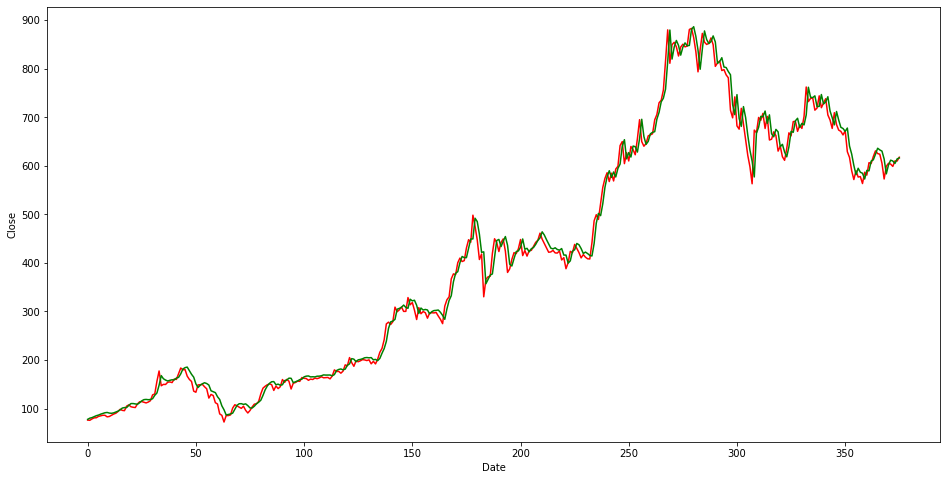

In [488]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(val_Y_reshaped[0], color = 'red', linewidth =1.5)
plt.plot(prediction_Val, color = 'green', linewidth = 1.5)

In [489]:
x_input=scaled_data_validate[376:].reshape(1,-1)
input = list(x_input)
temp_input = input[0].tolist()

In [490]:
lst_output=[]
n_steps=50
i=0
while(i<11):
    
    if(len(temp_input)>n_steps):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model3.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model3.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

In [491]:
out = scaler_2.inverse_transform(lst_output)
listTest = test['Close'].values.tolist()

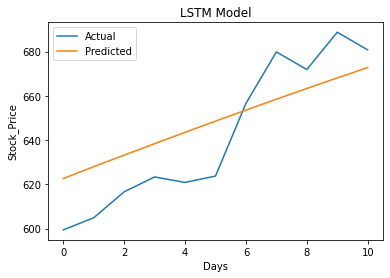

In [492]:
plt.xlabel('Days')
plt.ylabel('Stock_Price')
plt.title('LSTM Model')
plt.plot(np.array(listTest), label = 'Actual')
plt.plot(out, label='Predicted')
plt.legend()

In [493]:
#rmse value on the test data
result = mean_squared_error(np.array(listTest), out, squared=False)
print(result)

18.422015529773432
